# <font color ="orange">Used Libraries</font> 

In [281]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV

### <font color ="Purple">Reading Files</font> 

In [282]:
df_train = pd.read_csv("./csv_files/train.csv")
df_updated = pd.read_csv("./csv_files/train_updates.csv")
df_test =  pd.read_csv("./csv_files/test.csv")

In [283]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31390 entries, 0 to 31389
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seq_id            31390 non-null  int64  
 1   protein_sequence  31390 non-null  object 
 2   pH                31104 non-null  float64
 3   data_source       28043 non-null  object 
 4   tm                31390 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.2+ MB


In [284]:
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2434 entries, 0 to 2433
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seq_id            2434 non-null   int64  
 1   protein_sequence  25 non-null     object 
 2   pH                25 non-null     float64
 3   data_source       0 non-null      float64
 4   tm                25 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 95.2+ KB


In [285]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2413 entries, 0 to 2412
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   seq_id            2413 non-null   int64 
 1   protein_sequence  2413 non-null   object
 2   pH                2413 non-null   int64 
 3   data_source       2413 non-null   object
dtypes: int64(2), object(2)
memory usage: 75.5+ KB


### <font color ="Purple">Data Preparation and Inspection Step</font> 

In [287]:
for seq_id in df_updated.seq_id:
    df_train = df_train.drop(index = seq_id)

In [288]:
# Dropping seq_id and data source columns in train dataset 

In [289]:
df_train.drop(columns=["seq_id","data_source"],inplace=True)

In [290]:
df_train.describe().T.style.background_gradient("YlOrRd")

,count,mean,std,min,25%,50%,75%,max
pH,28670.000000,6.872918,0.792550,1.990000,7.000000,7.000000,7.000000,11.000000
tm,28956.000000,51.360399,12.060858,25.100000,43.600000,48.800000,54.600000,130.000000


In [291]:
# Checking any possible outliers inside the pH column 

In [292]:
df_train["pH"].describe()

count    28670.000000
mean         6.872918
std          0.792550
min          1.990000
25%          7.000000
50%          7.000000
75%          7.000000
max         11.000000
Name: pH, dtype: float64

In [293]:
df_train["tm"].value_counts()

50.0    200
45.0    178
49.7    176
49.0    175
48.4    174
       ... 
92.2      1
26.2      1
98.1      1
26.1      1
93.3      1
Name: tm, Length: 725, dtype: int64

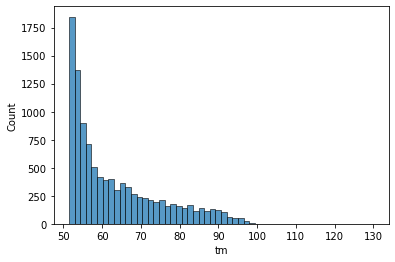

In [314]:
sns.histplot(df_train["tm"]);

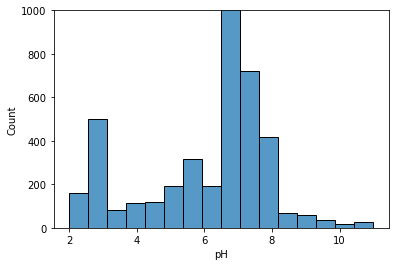

In [295]:
sns.histplot(df_train.pH)
plt.ylim(0,1000)
plt.show();

### <font color ="Purple">Data Preparation and Inspection Step</font> 
->> Somehow we need to use protein_sequence column because it plays an important role on determining enzyme stability

In [297]:
arr = []
for i in range (len(df_train)):
    arr.append(len(df_train["protein_sequence"].iloc[i]))
df_train["length"] = arr

In [298]:
new_arr = []
for i in range (len(df_test)):
    new_arr.append(len(df_test["protein_sequence"].iloc[i]))
df_test["length"] = new_arr

In [299]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28956 entries, 0 to 31389
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   protein_sequence  28956 non-null  object 
 1   pH                28670 non-null  float64
 2   tm                28956 non-null  float64
 3   length            28956 non-null  int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 1.1+ MB


In [300]:
df_train.head()

,protein_sequence,pH,tm,length
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,265
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5,1451


### <font color ="red">->> Proteins are built from a set of only twenty amino acids, each of which has a unique side chain. The side chains of amino acids have different chemistries. </font> 

In [302]:
amino_acids= ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
for letter in amino_acids:
    df_train[letter] = df_train.protein_sequence.str.count(letter)
    df_test[letter] = df_test.protein_sequence.str.count(letter)

In [303]:
df_train.head()

,protein_sequence,pH,tm,length,A,C,D,E,F,G,...,M,N,P,Q,R,S,T,V,W,Y
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,45,1,13,30,13,38,...,8,5,18,6,25,11,14,37,4,3
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,28,0,10,52,6,18,...,2,6,8,22,30,14,12,13,3,3
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,50,9,27,32,21,65,...,6,15,20,25,31,33,30,30,3,16
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,265,20,5,19,29,12,16,...,2,9,16,9,10,16,19,14,3,4
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5,1451,86,14,78,78,32,84,...,31,65,128,54,63,148,120,124,16,47


### <font color ="red">->> Here tm means that the protein variant is more stable, so instead of using all dataset, we can take some part from it like rows which's tm value is bigger than 51.36 (mean of tm).</font> 

In [305]:
df_train = df_train[df_train["tm"]>51.36]

In [306]:
df_train.shape

(10637, 24)

### <font color ="Purple">Now we can deal with our model side</font>  

In [307]:
# fitting our model
X = df_train.drop(columns=["protein_sequence","tm"])
y = df_train["tm"]

In [308]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

### <font color ="red">->> First we will use our model without model tuning, also we are asked to use spearman metric</font> 

In [315]:
model = XGBRegressor().fit(X_train,y_train)
prediction = model.predict(X_test)
corr, p = spearmanr(y_test,prediction)
print("Spearman Correlation: ",corr)

Spearman Correlation:  0.7323745161407725


### <font color ="red">->> Now we can measure by using tuned parameters, by gridsearchcv we can find best parameters</font>  

In [310]:
model = XGBRegressor()
params = {"n_estimators":[100,200,300],"max_depth":[3,5,7],"learning_rate":[0.1,0.05,0.001]}
tuned_model = GridSearchCV(model,param_grid=params,cv=5,verbose=2,n_jobs=-1).fit(X_train,y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [311]:
# The best params are
tuned_model.best_params_

{'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300}

### <font color ="red">->> We can create our final model by using these best parameters</font>  

In [312]:
final_model = XGBRegressor(n_estimators=300,learning_rate=0.05,max_depth=7).fit(X_train,y_train)
final_prediction = final_model.predict(X_test)
corr, p = spearmanr(y_test,final_prediction)
print("Spearman Correlation with Tuned Parameters: ",corr)
# as we can see, after tuning process we got 0.02 difference 

Spearman Correlation with Tuned Parameters:  0.7462864638015105


### <font color ="red">->> We can graph the feature importances</font>
->> As we can see below, almost half of aminoacids have high importance rather than others.

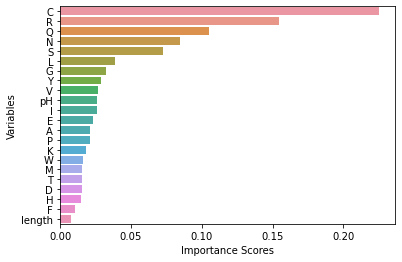

In [313]:
importance = pd.DataFrame({"Importance":final_model.feature_importances_},index=X_train.columns)
df = importance.sort_values(by="Importance",ascending=False)
sns.barplot(x="Importance",y=df.index,data=df)
plt.ylabel("Variables")
plt.xlabel("Importance Scores")
plt.show();